In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab13.ipynb")

# Lab 13: Clustering

In this lab you will explore K-Means, Agglomerative Clustering, and Spectral Clustering.

### Due Date

This assignment is due at **Saturday, August 7th** at 11:59 pm PDT.

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Lab Walkthrough Video

In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

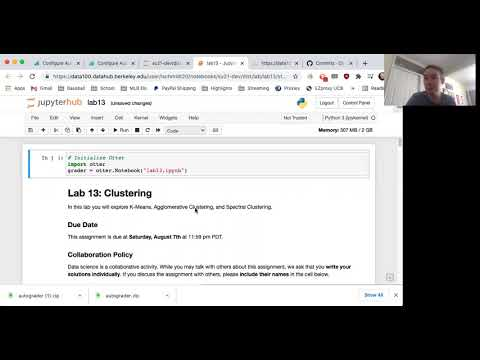

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("Q3YtRKnJEpo", list = 'PLQCcNQgUcDfpSyJ9K5x10XmoAKbCJjbT2', listType = 'playlist')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster

## Vanilla Example

Let us begin with a toy dataset with three groups that are completely separated with the variables given. There are the same number of points per group and the same variance within each group.

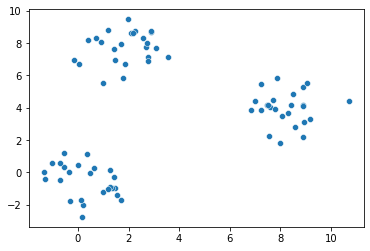

In [4]:
np.random.seed(1337)

c1 = np.random.normal(size = (25, 2))
c2 = np.array([2, 8]) + np.random.normal(size = (25, 2))
c3 = np.array([8, 4]) + np.random.normal(size = (25, 2))

x1 = np.vstack((c1, c2, c3))

sns.scatterplot(x = x1[:, 0], y = x1[:, 1]);

Running the K-Means algorithm, we can see that it is able to accurately pick out the three initial clusters. 

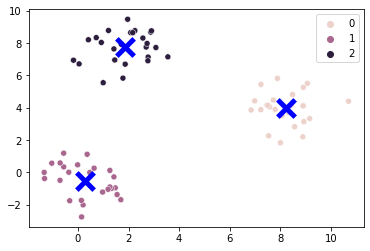

In [5]:
kmeans = cluster.KMeans(n_clusters = 3, random_state = 42).fit(x1)
sns.scatterplot(x = x1[:, 0], y = x1[:, 1], hue = kmeans.labels_)
sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1], color = 'blue', marker = 'x', s = 300, linewidth = 5);

## Question 1

In the previous example, the K-Means algorithm was able to accurately find the three initial clusters. However, changing the starting centers for K-Means can change the final clusters that K-Means gives us. Change the initial centers to the points `[0, 1]`, `[1, 1]`, and `[2, 2]`; and fit a [`cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) object called `kmeans_q1` on the toy dataset from the previous example. Keep the `random_state` parameter as 42 and the `n_clusters` parameter as 3.

**Hint:** You will need to change the `init` and `n_init` parameters in `cluster.KMeans`.

<!--
BEGIN QUESTION
name: q1
-->

In [6]:
kmeans_q1 = cluster.KMeans(n_clusters = 3, init = np.array([[0, 1], [1, 1], [2, 2]]), n_init = 1).fit(x1)

In [7]:
grader.check("q1")

q1 results: All test cases passed!

Running the K-Means algorithm with these centers gives us a different result from before, and this particular run of K-Means was unable to accurately find the three initial clusters.

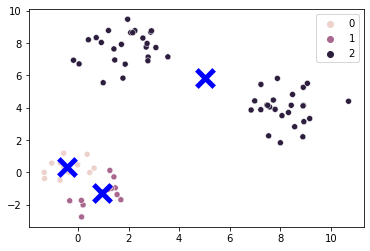

In [8]:
sns.scatterplot(x = x1[:, 0], y = x1[:, 1], hue = kmeans_q1.labels_)
sns.scatterplot(x = kmeans_q1.cluster_centers_[:, 0], y = kmeans_q1.cluster_centers_[:, 1], color = 'blue', marker = 'x', s = 300, linewidth = 5);

## Question 2

Sometimes, K-Means will have a difficult time finding the "correct" clusters even with ideal starting centers. For example, consider the data below. There are two groups of different sizes in two different senses. The smaller group has both smaller variability and is less numerous, and the larger of the two groups is more diffuse and populated.

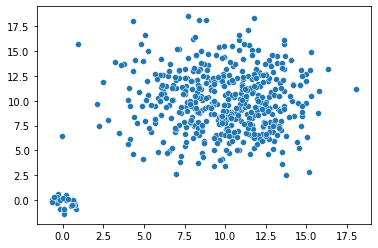

In [9]:
np.random.seed(1337)

c1 = 0.5 * np.random.normal(size = (25, 2))
c2 = np.array([10, 10]) + 3 * np.random.normal(size = (475, 2))

x2 = np.vstack((c1, c2))

sns.scatterplot(x = x2[:, 0], y = x2[:, 1]);

### Question 2a

Fit a `cluster.KMeans` object called `kmeans_q2a` on the dataset above with two clusters and a `random_state` parameter of 42.

<!--
BEGIN QUESTION
name: q2a
-->

In [10]:
kmeans_q2a = cluster.KMeans(n_clusters = 2, random_state = 42).fit(x2)

In [11]:
grader.check("q2a")

q2a results: All test cases passed!

(For notational simplicity we will call the initial cluster on the bottom left $A$ and the initial cluster on the top right $B$. We will call the bottom left cluster found by K-Means as cluster $a$ and the top right cluster found by K-Means as cluster $b$.) 

As seen below, K-Means is unable to find the two intial clusters because cluster $A$ includes points from cluster $B$. Recall that K-Means attempts to minimize inertia, so it makes sense that points in the bottom left of cluster $B$ would prefer to be in cluster $A$ rather than cluster $B$. If these points were in cluster $B$ instead, then the resulting cluster assignments would have a larger distortion.

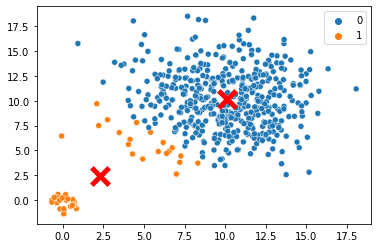

In [12]:
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = kmeans_q2a.labels_)
sns.scatterplot(x = kmeans_q2a.cluster_centers_[:, 0], y = kmeans_q2a.cluster_centers_[:, 1], color = 'red', marker = 'x', s = 300, linewidth = 5);

### Question 2b

It turns out agglomerative clustering works better for this task, as long as we choose the right definition of distance between two clusters. Recall that agglomerative clustering starts with every data point in its own cluster and iteratively joins the two closest clusters until there are $k$ clusters remaining. However, the "distance" between two clusters is ambiguous. 

In Lecture 24 we used the maximum distance between a point in the first cluster and a point in the second as this notion of distance, but there are other ways to define the distance between two clusters. 

Our choice of definition for the distance is sometimes called the "linkage criterion." We will discuss three linkage criteria, each of which is a different definition of "distance" between two clusters:

- Complete linkage considers the distance between two clusters as the **maximum** distance between a point in the first cluster and a point in the second. This is what we did in Lecture 24.
- Single linkage considers the distance between two clusters as the **minimum** distance between a point in the first cluster and a point in the second.
- Average linkage considers the distance between two clusters as the **average** distance between a point in the first cluster and a point in the second.

Below, we fit a [`cluster.AgglomerativeClustering`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) object called `agg_complete` on the dataset above with two clusters, using the **complete linkage criterion**.

In [13]:
agg_complete = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'complete').fit(x2)

Below we visualize the results of your model. Note that complete linkage agglomerative clustering has the same issue as k-Means in that the bottom left cluster found by complete linkage agglomerative clustering includes points from the top right cluster. However, we can remedy this by picking a different linkage criterion.

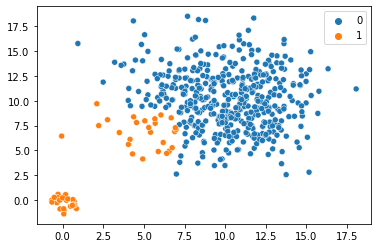

In [14]:
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = agg_complete.labels_);

### Question 2b

Now, use the **single linkage criterion** to fit a `cluster.AgglomerativeClustering` object called `agg_single` on the dataset above with two clusters.

<!--
BEGIN QUESTION
name: q2b
-->

In [15]:
agg_single = cluster.AgglomerativeClustering(n_clusters = 2, linkage = 'single').fit(x2)

In [16]:
grader.check("q2b")

q2b results: All test cases passed!

Finally, we see that single linkage agglomerative clustering is able to find the two initial clusters.

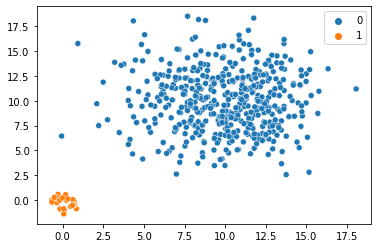

In [17]:
sns.scatterplot(x = x2[:, 0], y = x2[:, 1], hue = agg_single.labels_);

You might be curious why single linkage "works" while complete linkage does not in this scenario; we will leave this as an exercise for students who are interested.

## Question 3

Another example when k-means fails is when the clusters have odd shapes. For example, look at the following dataset.

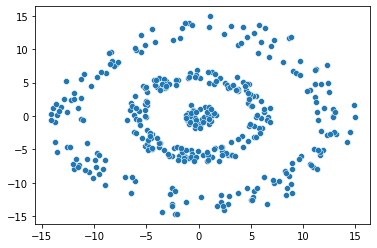

In [18]:
np.random.seed(100)

data = np.random.normal(0, 7, size = (1000, 2))
lengths = np.linalg.norm(data, axis = 1, ord = 2)
x3 = data[(lengths < 2) | ((lengths > 5) & (lengths < 7)) | ((lengths > 11) & (lengths < 15))]

sns.scatterplot(x = x3[:, 0], y = x3[:, 1]);

Looking at this data, we might say there are 3 clusters, corresponding to each of the 3 concentric circles, with the same center. However, k-means will fail.

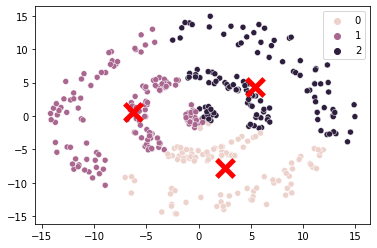

In [19]:
kmeans_q3 = cluster.KMeans(n_clusters = 3, random_state = 42).fit(x3)
sns.scatterplot(x = x3[:, 0], y = x3[:, 1], hue = kmeans_q3.labels_)
sns.scatterplot(x = kmeans_q3.cluster_centers_[:, 0], y = kmeans_q3.cluster_centers_[:, 1], color = 'red', marker = 'x', s = 300, linewidth = 5);

Let's try spectral clustering instead. 

In the cell below, create and fit a `cluster.SpectralClustering` object, and assign it to `spectral`. Use 3 clusters, and make sure you set `affinity` to `"nearest_neighbors"` and a `random_state` of 10.

Ignore any warnings about the graph not being fully connected.

<!--
BEGIN QUESTION
name: q3
-->

In [20]:
spectral = cluster.SpectralClustering(n_clusters = 3, random_state = 10, affinity = 'nearest_neighbors').fit(x3)

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [21]:
grader.check("q3")

q3 results: All test cases passed!

Below, we see that spectral clustering is able to find the three rings, when k-means does not.

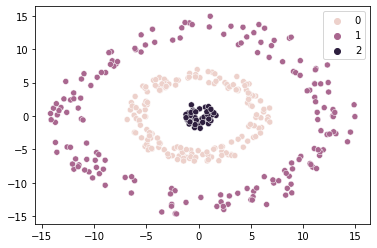

In [22]:
sns.scatterplot(x = x3[:, 0], y = x3[:, 1], hue = spectral.labels_);

## Question 4

In the previous three questions, we looked at clustering on two dimensional datasets. However, we can easily use clustering on data which have more than two dimensions. For this, let us turn to a World Bank dataset, containing various features for the world's countries.

This data comes from https://databank.worldbank.org/source/world-development-indicators#.


In [23]:
world_bank_data = pd.read_csv("world_bank_data.csv", index_col = 'country')
world_bank_data.head(5)

,Age dependency ratio (% of working-age population),"Age dependency ratio, old (% of working-age population)","Age dependency ratio, young (% of working-age population)","Bird species, threatened",Business extent of disclosure index (0=less disclosure to 10=more disclosure),"Contributing family workers, female (% of female employment) (modeled ILO estimate)","Contributing family workers, male (% of male employment) (modeled ILO estimate)","Contributing family workers, total (% of total employment) (modeled ILO estimate)",Cost of business start-up procedures (% of GNI per capita),"Cost of business start-up procedures, female (% of GNI per capita)",...,"Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)",Urban population,Urban population (% of total population),Urban population growth (annual %),"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)"
country,,,,,,,,,,,,,,,,,,,,,
Algeria,57.508032,10.021442,47.486590,15.0,4.0,2.720000,1.836,1.978000,0.0,11.8,...,29.952999,30670086.0,72.629,2.804996,24.337001,27.227001,26.762000,73.734001,68.160004,69.056000
Afghanistan,84.077656,4.758273,79.319383,16.0,8.0,71.780998,9.606,31.577999,0.0,6.4,...,2.639000,9477100.0,25.495,3.350383,95.573997,85.993001,89.378998,4.282000,13.292000,10.108000
Albania,45.810037,20.041214,25.768823,8.0,9.0,37.987000,20.795,28.076000,0.0,11.3,...,30.979000,1728969.0,60.319,1.317162,54.663000,54.994001,54.854000,44.320999,41.542999,42.720001
American Samoa,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,48339.0,87.153,-0.299516,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,67813.0,88.062,-0.092859,NaN,NaN,NaN,NaN,NaN,NaN


There are some missing values. For the sake of convenience and of keeping the lab short, we will fill them all with zeros. 

In [24]:
world_bank_data = world_bank_data.fillna(0)

Like with PCA, it sometimes makes sense to center and scale our data so that features with higher variance don't dominate the analysis. For example, without standardization, statistics like population will completely dominate features like "percent of total population that live in urban areas." This is because the range of populations is on the order of billions, whereas percentages are always between 0 and 100. The ultimate effect is that many of our columns are not really considered by our clustering algorithm.

Below, fit a `cluster.KMeans` object called `kmeans_q4` with four clusters and a `random_state` parameter of 42.

Make sure you should use a centered and scaled version of the world bank data. By centered and scaled we mean that the mean in each column should be zero and the variance should be 1.

<!--
BEGIN QUESTION
name: q4
-->

In [25]:
world_bank_standardized = (world_bank_data - np.mean(world_bank_data, axis = 0)) / np.std(world_bank_data, axis = 0)
kmeans_q4 = cluster.KMeans(n_clusters = 4, random_state = 42).fit(world_bank_standardized)

In [26]:
grader.check("q4")

q4 results: All test cases passed!

Looking at these new clusters, we see that they seem to correspond to:

0: Very small countries.

1: Developed countries.

2: Less developed countries.

3: Huge countries.

In [27]:
labeled_world_bank_data_q4 = pd.Series(kmeans_q4.labels_, name = "cluster", index  = world_bank_data.index).to_frame()

In [28]:
list(labeled_world_bank_data_q4.query('cluster == 0').index)

['American Samoa',
 'Andorra',
 'Aruba',
 'Bermuda',
 'British Virgin Islands',
 'Cayman Islands',
 'Curacao',
 'Dominica',
 'Faroe Islands',
 'Gibraltar',
 'Greenland',
 'Isle of Man',
 'Kosovo',
 'Liechtenstein',
 'Marshall Islands',
 'Monaco',
 'Nauru',
 'Northern Mariana Islands',
 'Palau',
 'San Marino',
 'Sint Maarten (Dutch part)',
 'St. Kitts and Nevis',
 'St. Martin (French part)',
 'Turks and Caicos Islands',
 'Tuvalu']

In [29]:
list(labeled_world_bank_data_q4.query('cluster == 1').index)

['Albania',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas, The',
 'Bahrain',
 'Barbados',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Canada',
 'Channel Islands',
 'Chile',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominican Republic',
 'El Salvador',
 'Estonia',
 'Finland',
 'France',
 'French Polynesia',
 'Georgia',
 'Germany',
 'Greece',
 'Grenada',
 'Guam',
 'Hong Kong SAR, China',
 'Hungary',
 'Iceland',
 'Iran, Islamic Rep.',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Korea, Rep.',
 'Kuwait',
 'Latvia',
 'Lebanon',
 'Libya',
 'Lithuania',
 'Luxembourg',
 'Macao SAR, China',
 'Malaysia',
 'Maldives',
 'Malta',
 'Mauritius',
 'Mexico',
 'Moldova',
 'Montenegro',
 'Netherlands',
 'New Caledonia',
 'New Zealand',
 'North Macedonia',
 'Norway',
 'Oman',
 'Panama',
 'Poland',
 'Portugal',

In [30]:
list(labeled_world_bank_data_q4.query('cluster == 2').index)

['Algeria',
 'Afghanistan',
 'Angola',
 'Bangladesh',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Djibouti',
 'Ecuador',
 'Egypt, Arab Rep.',
 'Equatorial Guinea',
 'Eritrea',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Gabon',
 'Gambia, The',
 'Ghana',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Indonesia',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Korea, Dem. People’s Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Micronesia, Fed. Sts.',
 'Mongolia',
 'Morocco',
 'Mozambique',
 'Myanmar',
 'Namibia',
 'Nepal',
 'Nicaragua',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Papua New Guinea',
 'Paraguay',
 'Peru',
 'Philippines',
 'Rwanda',
 'Samoa',
 'Sao Tome and Principe',
 'Senegal',
 'Sierra Leone',
 'Solomon Islands',


In [31]:
list(labeled_world_bank_data_q4.query('cluster == 3').index)

['China', 'India', 'United States']

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [32]:
grader.check_all()

q1 results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [33]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)